In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pickle
import math

trunc_normal= tf.truncated_normal_initializer(stddev=1)
normal = tf.random_normal_initializer(stddev=1)

from architectures.data_processing import *
from architectures.utils.toolbox import *
from architectures.DNN import *

# IMPORTING THE DATASET

In [2]:
l_index=1
mag_index=1
Ds_mass= 1968

In [3]:
MC_sig_dict, data_bkg_dict = load_datasets(l_index, mag_index)
m=MC_sig_dict["Ds_ConsD_M"].shape[0]
n=data_bkg_dict["Ds_ConsD_M"].shape[0]

print('Signal MC amounts to {0} while bkg data amounts to {1}'.format(m,n))

Signal MC amounts to 23821 while bkg data amounts to 86051


In [4]:
#Normalising the Chi2 vertex fits to the NDoF

MC_sig_dict["Ds_ENDVERTEX_CHI2"]=MC_sig_dict["Ds_ENDVERTEX_CHI2"]/MC_sig_dict["Ds_ENDVERTEX_NDOF"]
MC_sig_dict["Ds_OWNPV_CHI2"]=MC_sig_dict["Ds_OWNPV_CHI2"]/MC_sig_dict["Ds_OWNPV_NDOF"]
MC_sig_dict["Ds_IPCHI2_OWNPV"]=MC_sig_dict["Ds_IPCHI2_OWNPV"]/MC_sig_dict["Ds_ENDVERTEX_NDOF"]

del MC_sig_dict["Ds_ENDVERTEX_NDOF"]
del MC_sig_dict["Ds_OWNPV_NDOF"]

data_bkg_dict["Ds_ENDVERTEX_CHI2"]=data_bkg_dict["Ds_ENDVERTEX_CHI2"]/data_bkg_dict["Ds_ENDVERTEX_NDOF"]
data_bkg_dict["Ds_OWNPV_CHI2"]=data_bkg_dict["Ds_OWNPV_CHI2"]/data_bkg_dict["Ds_OWNPV_NDOF"]
data_bkg_dict["Ds_IPCHI2_OWNPV"]=data_bkg_dict["Ds_IPCHI2_OWNPV"]/data_bkg_dict["Ds_ENDVERTEX_NDOF"]

del data_bkg_dict["Ds_ENDVERTEX_NDOF"]
del data_bkg_dict["Ds_OWNPV_NDOF"]

data_bkg_dict["phi_ENDVERTEX_CHI2"]=data_bkg_dict["phi_ENDVERTEX_CHI2"]/data_bkg_dict["phi_ENDVERTEX_NDOF"]
data_bkg_dict["phi_OWNPV_CHI2"]=data_bkg_dict["phi_OWNPV_CHI2"]/data_bkg_dict["phi_OWNPV_NDOF"]
data_bkg_dict["phi_IPCHI2_OWNPV"]=data_bkg_dict["phi_IPCHI2_OWNPV"]/data_bkg_dict["phi_ENDVERTEX_NDOF"]

del data_bkg_dict["phi_ENDVERTEX_NDOF"]
del data_bkg_dict["phi_OWNPV_NDOF"]

In [5]:
branches_needed = [
                    "Ds_ENDVERTEX_CHI2",
                    #"Ds_ENDVERTEX_NDOF",
                    "Ds_OWNPV_CHI2",
                    #"Ds_OWNPV_NDOF",
                    "Ds_IPCHI2_OWNPV",
                    "Ds_IP_OWNPV",
                    "Ds_DIRA_OWNPV",
                    #l_flv[l_index]+"_plus_MC15TuneV1_ProbNN"+l_flv[l_index],
                    #"Ds_Hlt1TrackMVADecision_TOS",
                    #"Ds_Hlt2RareCharmD2Pi"+l_flv[l_index].capitalize()+l_flv[l_index].capitalize()+"OSDecision_TOS",
                    #"Ds_Hlt2Phys_TOS",
                    "phi_ENDVERTEX_CHI2",
                    #"phi_ENDVERTEX_NDOF",
                    "phi_OWNPV_CHI2",
                    #"phi_OWNPV_NDOF",
                    "phi_IPCHI2_OWNPV",
                    "phi_IP_OWNPV",
                    "phi_DIRA_OWNPV",
                    "Ds_ConsD_M",
                  ] 

In [6]:
#Number of input features

dim=len(branches_needed)

In [7]:
#Convert data dictionaries to arrays for NN

MC_sig = extract_array(MC_sig_dict, branches_needed, dim, m)
data_bkg = extract_array(data_bkg_dict, branches_needed, dim, n)

In [8]:
#Add 0/1 label for bkg/sig

MC_sig_labelled=add_labels(MC_sig,signal=True)
data_bkg_labelled=add_labels(data_bkg,signal=False)

In [9]:
#SOME CROSS CHECKS
#MC_sig.shape==data_bkg.shape
#MC_sig_labelled.shape[1]==dim+1==data_bkg_labelled.shape[1]
#data_bkg_labelled[:,dim].sum()==0
#(MC_sig_labelled[:,dim].sum()/m)==1

In [10]:
#Establish train/val/test sizes

val_size=4000
test_size=4000

train_size=MC_sig.shape[0]+data_bkg.shape[0]-val_size-test_size
(train_size, val_size, test_size)

(101872, 4000, 4000)

In [11]:
#Merge MC sig and data bkg, shuffle it

data=np.concatenate((MC_sig_labelled,data_bkg_labelled), axis =0)
np.random.seed(1)
np.random.shuffle(data)

#Check that nothing is missing

data.shape[0]==train_size+val_size+test_size

True

In [12]:
#Strip away the label column and convert it to a one-hot encoding

X=data[:,0:dim]
Y_labels=data[:,dim].astype(int)
Y_labels=Y_labels.reshape(train_size+val_size+test_size,1)
Y_labels_hot = to_one_hot(Y_labels)
Y_labels=Y_labels_hot


In [13]:
#Divide the dataset in train/val/test sets 

X_train_0 = X[0:train_size]
Y_train = Y_labels[0:train_size]

X_val_0 = X[train_size:train_size+val_size]
Y_val = Y_labels[train_size:train_size+val_size]

X_test_0 = X[train_size+val_size:train_size+val_size+test_size]
Y_test = Y_labels[train_size+val_size:train_size+val_size+test_size]

In [14]:
branches_needed

['Ds_ENDVERTEX_CHI2',
 'Ds_OWNPV_CHI2',
 'Ds_IPCHI2_OWNPV',
 'Ds_IP_OWNPV',
 'Ds_DIRA_OWNPV',
 'phi_ENDVERTEX_CHI2',
 'phi_OWNPV_CHI2',
 'phi_IPCHI2_OWNPV',
 'phi_IP_OWNPV',
 'phi_DIRA_OWNPV',
 'Ds_ConsD_M']

In [15]:
#Strip out the reconstructed Ds mass

X_train = X_train_0[:,0:dim-1]
X_val = X_val_0[:,0:dim-1]
X_test = X_test_0[:,0:dim-1]
dim=X_train.shape[1]

# SETTING UP THE NETWORK

In [29]:
#task='TRAIN'
task='TEST'

PATH=l_flv[l_index]+'_Mag'+mag_status[mag_index]+'_test_4'

In [30]:
if task =='TRAIN' and os.path.exists(PATH+'/hyper_parameters.pkl'):
    with open(PATH+'/hyper_parameters.pkl', 'rb') as f:  
        hyper_dict = pickle.load(f)
        
    m=hyper_dict["m"]
    test_size=hyper_dict["test_size"]
    val_size=hyper_dict["val_size"]
    LEARNING_RATE=hyper_dict["LEARNING_RATE"]
    BETA1=hyper_dict["BETA1"]
    BATCH_SIZE=hyper_dict["BATCH_SIZE"]
    EPOCHS=hyper_dict["EPOCHS"]
    VAL_PERIOD=hyper_dict["VAL_PERIOD"]
    SEED=hyper_dict["SEED"]
    sizes=hyper_dict["sizes"]
    LAMBD=hyper_dict["LAMBD"]
    PATH=hyper_dict["PATH"]

elif task=='TRAIN' and not os.path.exists(PATH+'/hyper_parameters.pkl'):
    
    
    LEARNING_RATE = 0.001
    BETA1 = 0.5
    BATCH_SIZE = 64
    EPOCHS = 20
    VAL_PERIOD = 5
    SEED=1
    LAMBD=1.
    
    sizes = {
    'dense_layers': [
                        #(16, 'bn', 0.8, lrelu, tf.glorot_uniform_initializer()),
                        #(8, 'bn', 0.5, lrelu, tf.glorot_uniform_initializer()),
                        #(16, 'bn',0.8, lrelu, tf.glorot_uniform_initializer()),
                        (32, 'bn', 0.8, lrelu, tf.glorot_uniform_initializer()),
                        (16, 'bn', 0.8, lrelu, tf.glorot_uniform_initializer()),
                        (8, 'bn', 0.8, lrelu, tf.glorot_uniform_initializer()),
                    ],
    'n_classes':2,
    }

In [31]:
if task == 'TEST' and os.path.exists(PATH+'/hyper_parameters.pkl'):
    with open(PATH+'/hyper_parameters.pkl', 'rb') as f:  
        hyper_dict = pickle.load(f)
        #for key, item in hyper_dict.items():
        #    print(key+':'+str(item))
            
    m=hyper_dict["m"]
    test_size=hyper_dict["test_size"]
    val_size=hyper_dict["val_size"]
    LEARNING_RATE=hyper_dict["LEARNING_RATE"]
    BETA1=hyper_dict["BETA1"]
    BATCH_SIZE=hyper_dict["BATCH_SIZE"]
    EPOCHS=hyper_dict["EPOCHS"]
    VAL_PERIOD=hyper_dict["VAL_PERIOD"]
    SEED=hyper_dict["SEED"]
    sizes=hyper_dict["sizes"]
    LAMBD=hyper_dict["LAMBD"]
    PATH=hyper_dict["PATH"]

In [32]:
def bkg():
    
    tf.reset_default_graph()
    nn = DNN(dim, sizes,
              lr=LEARNING_RATE, beta1=BETA1, lambd=LAMBD,
              batch_size=BATCH_SIZE, epochs=EPOCHS,
              save_sample=VAL_PERIOD, path=PATH, seed=SEED)
    
    vars_to_train= tf.trainable_variables()
    
    if task == 'TRAIN':
        init_op = tf.global_variables_initializer()
        
    if task == 'TEST':
        vars_all = tf.global_variables()
        vars_to_init = list(set(vars_all)-set(vars_to_train))
        init_op = tf.variables_initializer(vars_to_init)
    
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
    
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        
        sess.run(init_op)

        if task=='TRAIN':
            print('\n Training...')
            
            if os.path.exists(PATH+'/CNN_model.ckpt.index'):
                saver.restore(sess,PATH+'/CNN_model.ckpt')
                print('Model restored.')
            
            nn.set_session(sess)
            nn.fit(X_train, Y_train, X_val, Y_val)
            
            save_path = saver.save(sess, PATH+'/CNN_model.ckpt')
            print("Model saved in path: %s" % save_path)
        
        if task=='TEST':
            print('\n Evaluate model on test set...')
            saver.restore(sess,PATH+'/CNN_model.ckpt')
            print('Model restored.')
            
            nn.set_session(sess)
            nn.test(X_test, Y_test)
            
            output = nn.predict(X_test)
            
            return output


In [33]:
if __name__=='__main__':

    if task == 'TRAIN':
        if not os.path.exists(PATH):
            os.mkdir(PATH)
    
        elif os.path.exists(PATH):
            if os.path.exists(PATH+'/checkpoint'):
                ans = input('A previous checkpoint already exists, choose the action to perform \n \n 1) Overwrite the current model saved at '+PATH+'/checkpoint \n 2) Start training a new model \n 3) Restore and continue training the previous model \n ')
                
                if ans == '1':
                    print('Overwriting existing model in '+PATH)
                    for file in os.listdir(PATH):
                        file_path = os.path.join(PATH, file)
                        try:
                            if os.path.isfile(file_path):
                                os.unlink(file_path)
                            #elif os.path.isdir(file_path): shutil.rmtree(file_path)
                        except Exception as e:
                            print(e)
                            
                elif ans == '2':
                    PATH = input('Specify the name of the model, a new directory will be created.\n')
                    os.mkdir(PATH)         
        bkg()

    elif task == 'TEST': 
        if not os.path.exists(PATH+'/checkpoint'):
            print('No checkpoint to test')
        else:
            output = bkg()

Input for propagation (?, 10)
Logits shape (?, 2)
Input for propagation (?, 10)
Logits shape (?, 2)

 Evaluate model on test set...
INFO:tensorflow:Restoring parameters from mu_MagDown_test_4/CNN_model.ckpt
Model restored.
Test accuracy: 0.9963


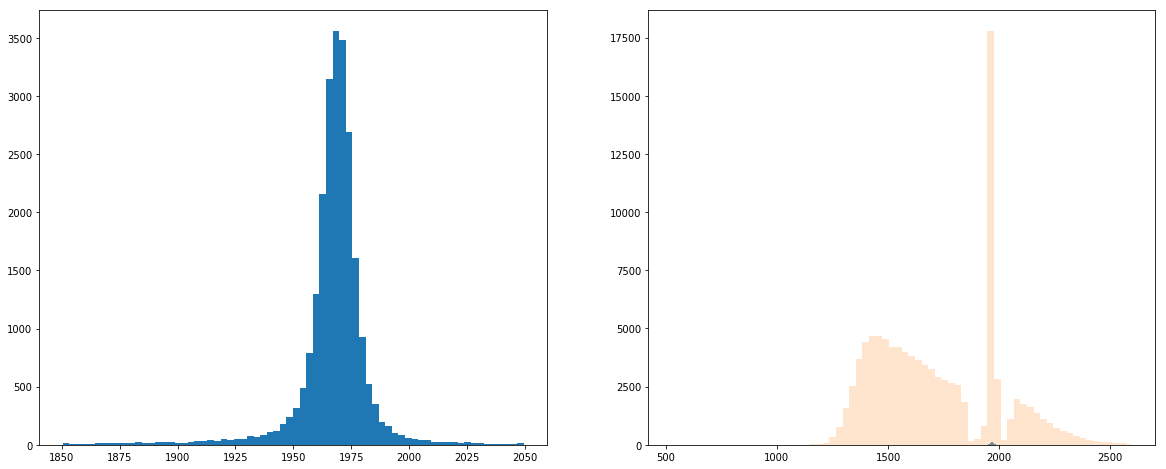

In [35]:
if task=='TEST':

    Ds_mass_MC =[MC_sig_dict["Ds_ConsD_M"][i][0] for i in range(m)]
    NN_selected = X_test_0[np.argmax(output, axis=1).astype(np.bool)]
    Ds_mass_sel_NN = [NN_selected[i][dim] for i in range(NN_selected.shape[0])]
    Ds_mass_train_NN =[X_train_0[i][dim] for i in range(X_train_0.shape[0])]

    plt.subplot(1,2,1)
    plt.hist(Ds_mass_MC,bins=70);
    plt.subplot(1,2,2)
    plt.hist(Ds_mass_sel_NN,alpha=0.8,bins=70);
    plt.hist(Ds_mass_train_NN,alpha=0.2,bins=70);

    fig=plt.gcf();
    fig.set_size_inches(20,8)

In [27]:
if task=='TRAIN':
    hyper_dict={
        'm':m,
        'test_size':test_size,
        'val_size':val_size,
        'LEARNING_RATE':LEARNING_RATE,
        'BETA1':BETA1,
        'BATCH_SIZE':BATCH_SIZE,
        'EPOCHS':EPOCHS,
        'VAL_PERIOD':VAL_PERIOD,
        'SEED':SEED,
        'sizes':sizes,
        'LAMBD':LAMBD,
        'PATH':PATH,
    }
    with open(PATH+'/hyper_parameters.pkl', 'wb') as f:  
        pickle.dump(hyper_dict, f)